In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [4]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"  #HMF_Slicing.bed
#BED_FILE_NAME = "HMF_Slicing.bed" 
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [5]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [6]:
def loadCNVforPatient(cnvFile,patientName):
    dfTumorCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfTumorCNV.iloc[0]
    for i in range(1, dfTumorCNV.shape[0]-1):
        if last['posEnd']<>dfTumorCNV.iloc[i]['posStart']:
            if last['chrom']==dfTumorCNV.iloc[i]['chrom']:
                dfTumorCNV.loc[len(dfTumorCNV)] = [last['chrom'],last['posEnd'], dfTumorCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfTumorCNV.loc[len(dfTumorCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfTumorCNV.iloc[i]['posStart']<>0:
                    dfTumorCNV.loc[len(dfTumorCNV)] = [dfTumorCNV.iloc[i]['chrom'],0, dfTumorCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfTumorCNV.iloc[i]
    #fix first record
    if dfTumorCNV.iloc[0]['posStart']<>0:
        dfTumorCNV.loc[len(dfTumorCNV)] = ['1',0, dfTumorCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfTumorCNV['chromPos']= dfTumorCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfTumorCNV['posStart'] / dfTumorCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfTumorCNV['chrom'] = dfTumorCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfTumorCNV['cappedCopyNum'] = dfTumorCNV['copyNum'].clip(upper=5)
    dfTumorCNV = dfTumorCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfTumorCNV['regionLength'] = (dfTumorCNV['posEnd']-dfTumorCNV['posStart'])
    dfTumorCNV['patientName']=patientName
    return dfTumorCNV

In [7]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [8]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [9]:
def cnvChart(dfTumorCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfTumorCNV['chromPos'], dfTumorCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [10]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [11]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>50)&\
                   (dfGermline['normalDP']<100)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [12]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [13]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [14]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [15]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,3])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [16]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [17]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,2])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [18]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

In [19]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [20]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [21]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(2)
    #ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [22]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[2])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['myCopyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList


### LOAD PON

In [23]:
def loadPONvcf(PONFile):
    numHeaderRows = 0
    with open(PONFile) as fp:
        while fp.readline()[0]=='#':
            numHeaderRows = numHeaderRows+1
    dfPON = pd.read_table(PONFile,skiprows =numHeaderRows-1, dtype={'#CHROM':'str','POS':'str'})  #names = CNV_COLUMNS
    dfPON['PON_COUNT'] = dfPON['INFO'].apply(lambda x: x.split('=')[1])
    dfPON.rename(columns={'#CHROM': 'chrom', 'POS': 'pos','REF':'ref','ALT':'alt'}, inplace=True)
    return dfPON

dfPON = loadPONvcf("/Users/peterpriestley/hmf/analyses/PON/PON.vcf")

### FIND ALL FILES

In [24]:
PATH = "/Users/peterpriestley/hmf/analyses/COLO829/"

In [25]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = "COLO829"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",tumorCNVFileName

germline = 170310_COLO829_v1.12_Somatic.annotatedSLICED.vcf
somatic = COLO829BL_COLO829_melted.vcf
patient = COLO829
CNV = COLO829_dedup.realigned.pileup.gz_CNVs


### LOAD VCFS

In [26]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'BL':'normal',patientID:'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID:'melted'},patientID)

reading vcf file: 170310_COLO829_v1.12_Somatic.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 341808
reading vcf file: COLO829BL_COLO829_melted.vcf
reading VCF File line: 1
Number variants loaded: 87269


In [27]:
somaticTruthVCFFilename = findFiles(PATH,"validated.vcf")[0]

In [28]:
#dfSomaticTruth = loadVCF(PATH,somaticTruthVCFFilename,{'COLO_829_Illumina':'truth','COLO_829_EPleasance':'EP','COLO_829_TGEN':'TGEN','COLO_829_GSC':'GSC'}
#,patientID)


In [29]:
dfSomaticTruth = loadVCF(PATH,somaticTruthVCFFilename,{'COLO_829_Illumina':'truth'},patientID)
dfSomaticTruth.head()

reading vcf file: _EGAZ00001226241_ListforNatureReports.IndelsandSNVs.final.Suppl1.snpEff.validated.vcf
reading VCF File line: 1
Number variants loaded: 35989


,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,truthallele,truthAF,truthDP,truthQS,truthSGT,truthindelDiff,truthSVLenMin,truthSVLenMax,truthSVStartMin,truthSVStartMax,patientName
0,1,696644,1:696644,1.002795,.,G,test,1,SNP,,PASS,,False,False,,,,,False,A,0.673469,49,-1,0/1,,,,,,COLO829
1,1,822939,1:822939,1.003302,.,C,test,1,SNP,,PASS,,False,False,,,,,False,T,0.747664,107,-1,0/1,,,,,,COLO829
2,1,883516,1:883516,1.003545,.,G,test,1,SNP,,PASS,,False,False,,,,,False,A,0.692308,65,-1,0/1,,,,,,COLO829
3,1,1117642,1:1117642,1.004484,.,C,test,1,SNP,,PASS,Default,False,False,,,,,False,T,0.741935,62,-1,0/1,,,,,,COLO829
4,1,1224077,1:1224077,1.004911,.,C,test,1,SNP,,PASS,,False,False,,,,,False,T,0.866667,15,-1,0/1,,,,,,COLO829


In [30]:
dfSomaticTruth['alt'] = dfSomaticTruth['truthallele']
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomaticTruth = dfSomaticTruth[['chrom','pos','ref','alt','truthDP','truthAF']]
dfSomatic = pd.merge(dfSomatic,dfSomaticTruth,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['inTruth']=(~dfSomatic.truthAF.isnull())

In [31]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PON_COUNT'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PON_COUNT,errors=coerce)>4

In [35]:
pd.pivot_table(dfSomatic[dfSomatic.consensus==True], values='pos', index=['variantType'], columns=['inPON'], aggfunc='count',margins=True).fillna("")

inPON,False,True,All
variantType,,,
INDEL,1010.0,1181.0,2191.0
SNP,40328.0,692.0,41020.0
All,41338.0,1873.0,43211.0


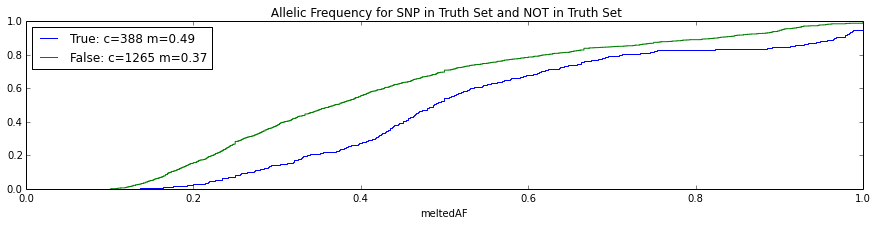

In [33]:
for truth in [True,False]:
    ser = dfSomatic[(dfSomatic['consensus']==True)&(dfSomatic['inPON']==False)&(dfSomatic.inTruth==truth)&(dfSomatic.variantType=='INDEL')]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency for SNP in Truth Set and NOT in Truth Set",figsize=[15,3],xlim=[0,1])

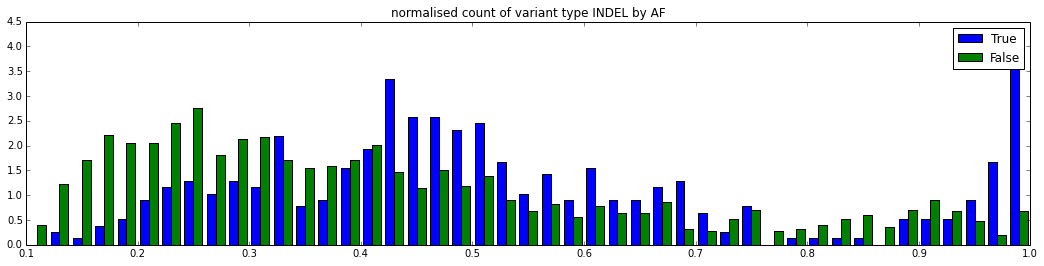

In [34]:
variantType = 'INDEL'
plt.figure(figsize=[18,4])
plt.hist([dfSomatic[(dfSomatic['consensus']==True)&(dfSomatic['inPON']==False)&(dfSomatic.inTruth==True)&
    (dfSomatic.variantType==variantType)]['meltedAF'].values,dfSomatic[(dfSomatic['consensus']==True)&
    (dfSomatic['inPON']==False)&(dfSomatic.inTruth==False)&(dfSomatic.variantType==variantType)]['meltedAF'].values],
    cumulative=False, normed=True, bins=50,range=(0.0,1.0),histtype='bar',stacked = False,rwidth=0.8,label=['True','False'])
plt.title('normalised count of variant type '+variantType+' by AF')
plt.legend()
plt.show()

### Load BAF and CNV and calculate median BAF per segment

In [35]:
dfBAF = createBAF(dfGermline)

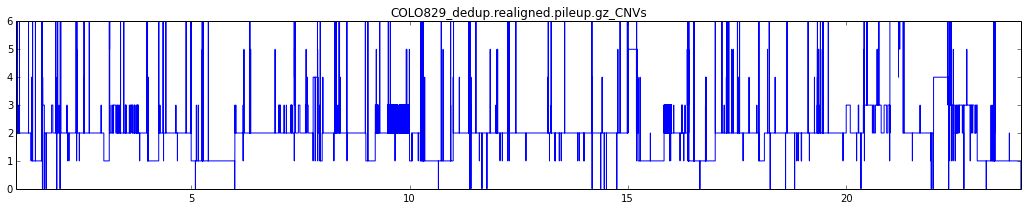

In [36]:
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientID)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientID)
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
cnvChart(dfTumorCNV,tumorCNVFileName,1,24)

### TUMOR PURITY

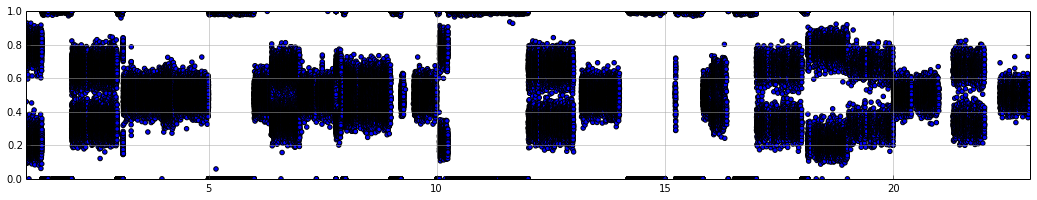

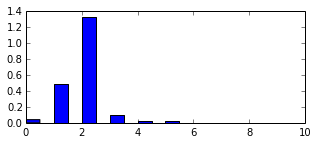

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:8261: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  'this looks transposed (shape is %d x %d)' % x.shape[::-1])


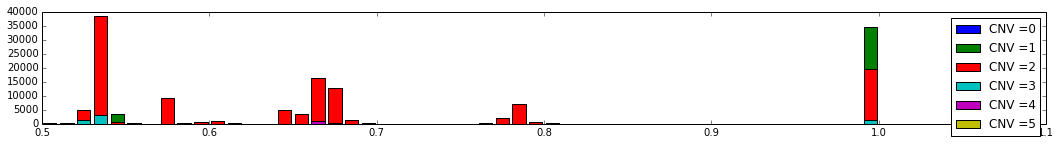

In [37]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfSom.chromPos, dfSom.BAF,c+fractionMin, c+fractionMax)
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfTumorCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfTumorCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,2])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [38]:
dfTumorCNV[(dfTumorCNV.chrom==10)&(dfTumorCNV.copyNum>=0)&(dfTumorCNV.mBAF>0.56)&(dfTumorCNV.mBAF<10.62)\
      &(dfTumorCNV.mBAFCount>100)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
1301,10,0,1,10.000000,7060000,1.000000,715
1315,10,10702000,2,10.078961,2717000,0.786667,201
1351,10,21295000,2,10.157118,3655000,0.782609,189
1381,10,33386000,1,10.246328,1924000,1.000000,191
1383,10,35311000,1,10.260531,3462000,1.000000,155
1409,10,42818000,1,10.315919,4147000,1.000000,216
1413,10,47149000,1,10.347874,42551000,1.000000,2925
1415,10,89712000,1,10.661911,8849000,1.000000,590
1417,10,98562000,1,10.727208,5627000,1.000000,297
1419,10,104191000,1,10.768740,23383000,1.000000,1655


### SOMATIC AF

In [39]:
#dfSomatic[(dfSomatic.consensus==True)&((dfSomatic.annWorstImpact=='MODERATE')|(dfSomatic.annWorstImpact=='HIGH'))]

In [40]:
pd.pivot_table(dfSomatic[dfSomatic.consensus==True], values='pos', index=['patientName','variantType','inPON'], columns=['inTruth'], aggfunc='count',margins=False).fillna("")

inTruth                        False  True 
patientName variantType inPON              
COLO829     INDEL       False    557    384
                        True    1237     13
            SNP         False   5047  35215
                        True     712     46

In [41]:
pd.pivot_table(dfSomatic[(dfSomatic.variantType == 'SNP')&(dfSomatic.consensus == True)&(dfSomatic.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

meltedallele,A,C,G,T,All
ref,,,,,
A,,830,1214,869,2913.0
C,2121,,384,14306,16811.0
G,14755,406,,2295,17456.0
T,853,1276,953,,3082.0
All,17729,2512,2551,17470,40262.0


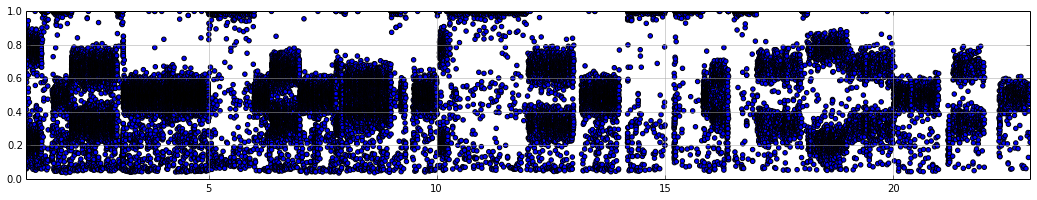

In [42]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

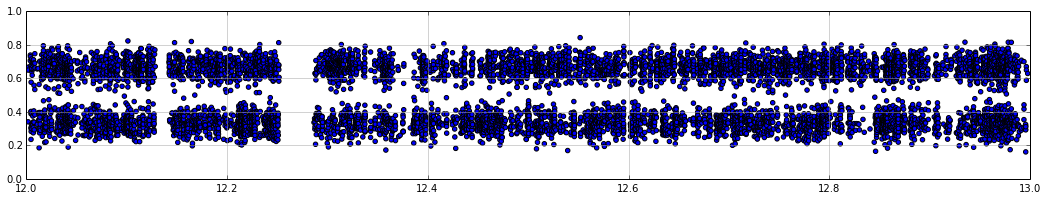

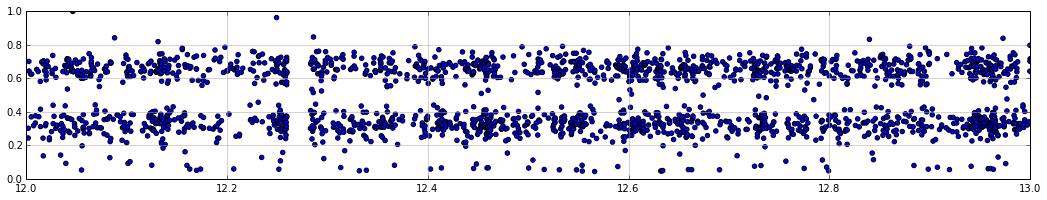

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
1497,12,2366000,2,12.017676,3719000,0.663043,353
1505,12,10508000,2,12.078505,3215000,0.674157,292
1509,12,13947000,2,12.104197,2399000,0.666667,225
1521,12,21800000,2,12.162867,5699000,0.670213,364
1525,12,28094000,2,12.209889,2874000,0.663265,353
1527,12,31087000,2,12.232249,2207000,0.674157,207
1570,12,38544000,2,12.287960,6664000,0.670330,493
1578,12,51564000,2,12.385232,6650000,0.663265,325
1638,12,84578000,2,12.631877,3657000,0.670588,285
1654,12,92384000,2,12.690196,3000000,0.666667,271


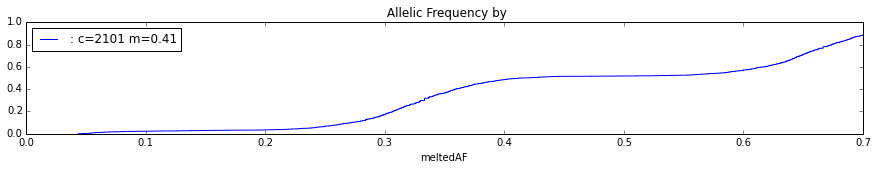

In [43]:
c,fractionMin,fractionMax = 12,0,1
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,2],xlim=[0.0,0.7])

#mbaf
dfTumorCNV[(dfTumorCNV.chromPos>c+fractionMin)&(dfTumorCNV.chromPos<c+fractionMax)&(dfTumorCNV.mBAFCount>200)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

### Somatic Peak Finding

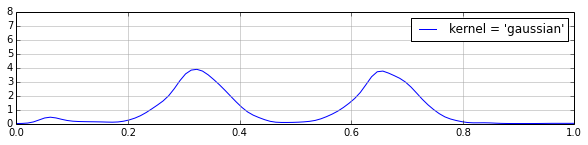

[0.06, 0.32, 0.65, 0.83, 0.96]

In [44]:
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens,1)

### RATIO

In [45]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)#names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)# names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
#dfTumorRatio = dfTumorRatio[(dfTumorRatio.Ratio_y > 0)]
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

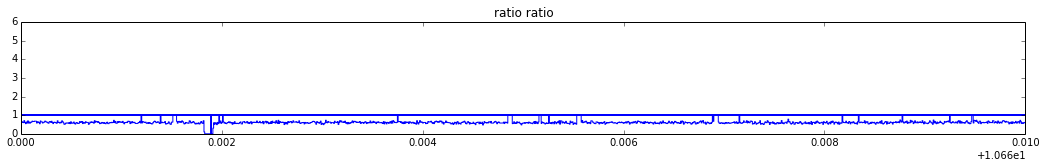

In [47]:
positionChart(dfTumorRatio,"ratio","ratio",10.66,10.67,6)

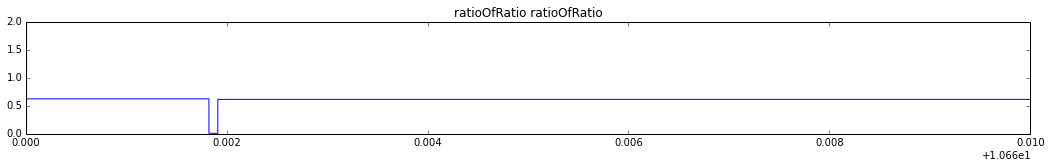

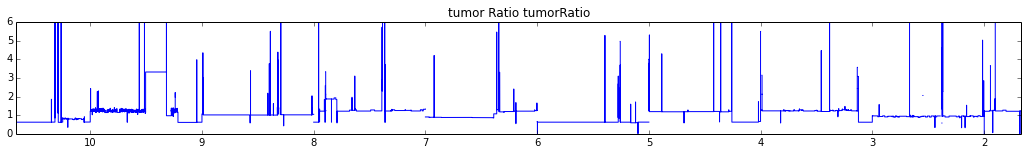

In [48]:
positionChart(dfTumorCNV,"ratioOfRatio","ratioOfRatio",10.66,10.67,2)
positionChart(dfTumorCNV,"tumor Ratio","tumorRatio",10.66,1.67,6)

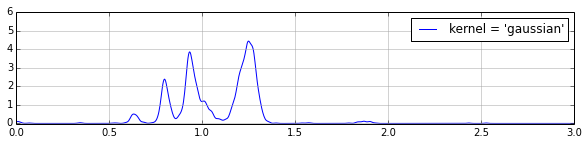

In [49]:
X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 3
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,6)
cnvPeaks = findPeaks(log_dens,X_range)

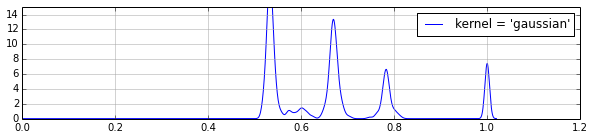

In [50]:
X = dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis]
X_range = 1.02
X_plot = np.linspace(0,X_range,1020)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,15)
mBAFPeaks = findPeaks(log_dens,X_range)

In [51]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['ratioOfRatio'])
pd.pivot_table(dfTumorCNV[dfTumorCNV.chrom==4], values='mBAFCount', index=['fittedBAFPeak'], columns=['fittedCNVPeak'], aggfunc='sum',margins=True).fillna("")

fittedCNVPeak,0.009,0.63,0.795,1.008,1.245,1.395,All
fittedBAFPeak,,,,,,,
0.532,0,3393.0,0,0,8777,0,12170.0
0.574,,157.0,,,,,157.0
All,0,3550.0,0,0,8777,0,12327.0


### GENE CNV ANALYSIS

In [52]:
# BEST ESTIMATE OF COPY NUMBER!
dfTumorCNV["myCopyNum"] = np.round(dfTumorCNV.fittedCNVPeak/0.63*2,0)

In [53]:
# LOAD CNV BED
CNV_BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
CNV_BED_FILE_NAME = "HMF_Slicing.Bed"
CNVBed = aVCF.loadBEDFile(CNV_BED_PATH,CNV_BED_FILE_NAME)

In [54]:
dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfTumorCNV,CNVBed,'COLO829'),columns= GENECNV_COLUMNS)

In [55]:
(dfGeneCNV[dfGeneCNV.minCopyNum<2])

,patientName,gene,chrom,posStart,posEnd,minCopyNum,cnvLabel
62,COLO829,ENST00000371953.3 (PTEN),10,89622870,89731687,0.0,loss


In [56]:
dfSomatic[(dfSomatic.annWorstImpact=='HIGH')&(dfSomatic.bedRegion=='')].sort_values('annGene')

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,alt,truthDP,truthAF,inTruth,PONCount,inPON
41291,9,38573127,9:38573127,9.273155,COSM36880,C,Intersection,4,SNP,,PASS,,False,True,ANKRD18A,HIGH,splice_acceptor_variant&intron_variant,splice_acceptor_variant&intron_variant|splice_...,True,T,0.455696,158,-1.0,0/1,,,,,,COLO829,T,160,0.468750,True,0,False
16088,3,121305072,3:121305072,3.612582,COSM36660,G,Intersection,4,SNP,,PASS,,False,True,ARGFX,HIGH,stop_gained,stop_gained,True,A,0.528846,103,-1.0,0/1,,,,,,COLO829,A,102,0.529412,True,0,False
27979,5,180375375,5:180375375,5.997016,rs10541574;COSM243261,GGTAA,freebayes,1,INDEL,DELETE,.,,True,True,BTNL8,HIGH,splice_donor_variant&splice_region_variant&int...,splice_donor_variant&splice_region_variant&int...,False,G,1.000000,4,-1.0,1/1,GTAA-,,,,,COLO829,G,NaN,NaN,False,265,True
6460,1,243328887,1:243328887,1.976242,rs199575184;COSM228300,G,mutect,1,SNP,,PASS,,True,True,CEP170,HIGH,stop_gained,stop_gained|stop_gained|stop_gained|stop_gaine...,False,T,0.043860,114,-1.0,0/1,,,,,,COLO829,T,NaN,NaN,False,123,True
28242,6,15546294,6:15546294,6.090853,.,C,freebayes-varscan,2,INDEL,INSERT,PASS,,False,False,DTNBP1,HIGH,frameshift_variant,frameshift_variant|sequence_feature|sequence_f...,True,CTT,0.204082,51,-1.0,0/1,TT+,,,,,COLO829,CTT,NaN,NaN,False,118,True
23142,4,191003048,4:191003048,4.999209,.,G,varscan,1,SNP,,PASS,,False,False,DUX4L4,HIGH,stop_gained,stop_gained|stop_gained|sequence_feature|intro...,False,A,0.126761,73,-1.0,0/1,,,,,,COLO829,A,NaN,NaN,False,87,True
23144,4,191003410,4:191003410,4.999211,.,G,varscan,1,SNP,,PASS,,False,False,DUX4L4,HIGH,stop_gained,stop_gained|stop_gained|intron_variant,False,T,0.106383,96,-1.0,0/1,,,,,,COLO829,T,NaN,NaN,False,0,False
36661,8,7153921,8:7153921,8.048878,rs201746613;COSM1600068,T,mutect,1,SNP,,PASS,,True,True,FAM90A20P,HIGH,splice_donor_variant&intron_variant,splice_donor_variant&intron_variant,False,C,0.088889,45,-1.0,0/1,,,,,,COLO829,C,NaN,NaN,False,5,True
64439,17,18380163,17:18380163,17.226370,rs68138124,GGA,freebayes,1,INDEL,DELETE,.,,True,False,LGALS9C,HIGH,frameshift_variant&start_lost,frameshift_variant&start_lost|frameshift_varia...,False,G,0.536232,72,-1.0,0/1,GA-,,,,,COLO829,G,NaN,NaN,False,555,True
17708,3,195389441,3:195389441,3.986704,.,G,Intersection,4,SNP,,PASS,,False,False,LINC00969,HIGH,splice_acceptor_variant&intron_variant,splice_acceptor_variant&intron_variant|splice_...,True,A,0.327434,113,-1.0,0/1,,,,,,COLO829,A,103,0.320388,True,0,False


### SV Analysis

In [57]:
svVCFFilename = findFiles(PATH,"somaticSV.vcf")[0]
print "SV =",svVCFFilename
dfSV = loadVCF(PATH,svVCFFilename,{patientID:'tumor'},patientID)

SV = somaticSV.vcf
reading vcf file: somaticSV.vcf
reading VCF File line: 1
Number variants loaded: 118


In [58]:
pd.pivot_table(dfSV[(dfSV.variantSubType<>"IGN")&(dfSV.tumorAF>=0.00)], values='id', index=['variantSubType'], columns=['variantType'], aggfunc='count').fillna("")

variantType,SV
variantSubType,
BND,34
DEL,33
DUP,19
INV,19


In [59]:
#dfTumorCNV[(dfTumorCNV.chrom==10)&(dfTumorCNV.copyNum>=0)&(dfTumorCNV.mBAF>0.05)&(dfTumorCNV.mBAF<10.62)\
#      &(dfTumorCNV.mBAFCount>100)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount','fittedCNVPeak','tumorRatio','normalRatio']]

In [60]:
dfSV[(dfSV.bedRegion<>"A")&(dfSV.variantSubType=="BND")&(dfSV.tumorAF>=0.05)][['chrom','pos','chromFrac','variantSubType','bedRegion','tumorallele','tumorAF','tumorSGT','tumorSVLenMin','tumorSVLenMax','tumorSVStartMin','tumorSVStartMax']]

,chrom,pos,chromFrac,variantSubType,bedRegion,tumorallele,tumorAF,tumorSGT,tumorSVLenMin,tumorSVLenMax,tumorSVStartMin,tumorSVStartMax
0,1,87337093,1.350399,BND,Default,T]10:33386475],0.160377,"89,",-192,191,87336902,87337285
10,3,25400602,3.128271,BND,Default,GTGAATCCATCA[12:72666892[,0.133705,311,-2,0,25400602,25400604
11,3,25400667,3.128272,BND,Default,C]10:60477528],0.057803,326,-262,262,25400405,25400929
12,3,25401059,3.128274,BND,Default,G[10:60477224[,0.166667,220,0,0,25401059,25401059
28,6,138774059,6.810998,BND,Default,[15:23717166[GTATATTATCT,0.071429,182,0,0,138774059,138774059
29,6,138774180,6.810999,BND,Default,T]15:23712619],0.056604,200,-2,0,138774180,138774182
40,7,150746657,7.947266,BND,Default,C[15:84810725[,0.468927,"94,",0,0,150746657,150746657
49,10,7059511,10.052086,BND,Default,]19:17396810]T,0.266187,102,-1,0,7059511,7059512
50,10,7132872,10.052628,BND,Default,G[19:17397640[,0.290000,"71,",-4,0,7132872,7132876
51,10,7634373,10.056328,BND,Default,[18:9868617[A,0.128440,"95,",0,0,7634373,7634373


In [61]:
def findMatchingBNDChromPos(df):
    # can 
    df['BNDMatchPos'] = ""
    for i in range(0,df.shape[0]):
        if df.iloc[i]['variantSubType'] == "BND":
            tmp = df.iloc[i]['tumorallele'].find("]")
            if tmp >= 0:
                df.iloc[i,df.columns.get_loc('BNDMatchPos')] = df.iloc[i]['tumorallele'][tmp+1:df.iloc[i]['tumorallele'].find("]",tmp+1)]
    return df

In [62]:
dfSV = findMatchingBNDChromPos(dfSV)

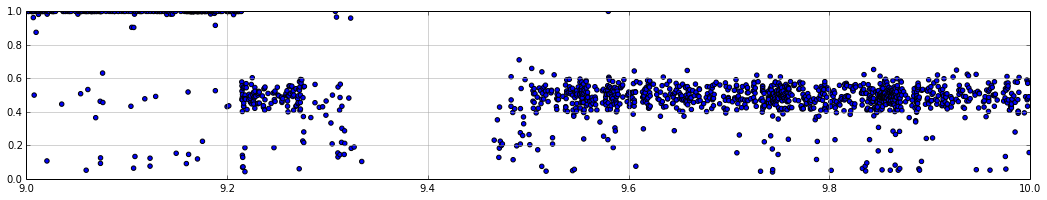

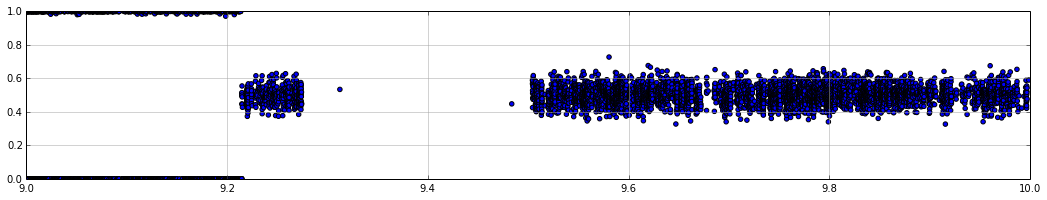

In [63]:
c,fractionMin,fractionMax = 9,0,1
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)

In [64]:
dfSV[(dfSV.variantSubType=="INS")&(dfSV.tumorAF>=0.08)][['chrom','pos','chromFrac','variantSubType','bedRegion','BNDMatchPos','tumorallele','tumorAF','tumorDP','tumorSGT','tumorSVLenMin','tumorSVLenMax','tumorSVStartMin','tumorSVStartMax']]

,chrom,pos,chromFrac,variantSubType,bedRegion,BNDMatchPos,tumorallele,tumorAF,tumorDP,tumorSGT,tumorSVLenMin,tumorSVLenMax,tumorSVStartMin,tumorSVStartMax


In [65]:
### MAKE SLICING FILE
dfSV.minBedPos
dfSV = dfSV[['chrom','pos','pos']]

AttributeError: 'DataFrame' object has no attribute 'minBedPos'

In [ ]:
dfSVBed = []
for i in range(0, dfSV.shape[0]-1):
    if dfSV.iloc[i]['tumorSVLenMax']>1000:
        dfSVBed.append(['chr'+dfSV.iloc[i]['chrom'],int(dfSV.iloc[i]['pos'])-200,int(dfSV.iloc[i]['pos'])+200])
        dfSVBed.append(['chr'+dfSV.iloc[i]['chrom'],int(dfSV.iloc[i]['pos'])+dfSV.iloc[i]['tumorSVLenMin']-200,int(dfSV.iloc[i]['pos'])+dfSV.iloc[i]['tumorSVLenMax']+200])
    else:
        dfSVBed.append(['chr'+dfSV.iloc[i]['chrom'],int(dfSV.iloc[i]['pos'])-200,int(dfSV.iloc[i]['pos'])+dfSV.iloc[i]['tumorSVLenMax']+200])

In [ ]:
import csv

with open(PATH+"SVSlice.bed", "wb") as f:
    writer = csv.writer(f,delimiter="\t")
    writer.writerows(dfSVBed)